# CGM preediction tests #
## Michael Strand / Chelsea Huynh ##


In [428]:
import pandas as pd
import numpy as np
import matplotlib as plt

# breathing table

raw_breathing = pd.read_csv('2014_10_02-10_56_44_Breathing.csv')
raw_breathing['Time'] = raw_breathing['Time'].str[10:]
raw_breathing_slim = raw_breathing.loc[(raw_breathing['Time']).str[-3:] == '420']
raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]

# ecg table

raw_ecg = pd.read_csv('2014_10_02-10_56_44_ECG.csv')
raw_ecg['Time'] = raw_ecg['Time'].str[10:]
raw_ecg_slim = raw_ecg.loc[(raw_ecg['Time']).str[-3:] == '424']
raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]

# trim glucose measures so we can properly shape our A matrix 

raw_glucose = pd.read_csv('P1_glucose.csv')
raw_glucose_day1 = raw_glucose.loc[(raw_glucose['date']).str[-1] == '2']
raw_glucose_day1 = raw_glucose_day1.drop('comments', axis=1)

# start at 10:56
raw_glucose_day1_trim = raw_glucose_day1.iloc[135:-30]
raw_glucose_day1_trim['time'] = raw_glucose_day1_trim['time'].str[:5]

# drop manual imputations for conistancy 
raw_glucose_day1_trim = raw_glucose_day1_trim.loc[(raw_glucose_day1_trim['type']) == 'cgm']

C:\Users\mikew\AppData\Local\Temp/ipykernel_10404/784069599.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_breathing_slim['Time'] = raw_breathing_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_10404/784069599.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_ecg_slim['Time'] = raw_ecg_slim['Time'].str[:9]
C:\Users\mikew\AppData\Local\Temp/ipykernel_10404/784069599.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [429]:
raw_summary = pd.read_csv('2014_10_02-10_56_44_Summary.csv')
raw_summary = raw_summary.iloc[436:-424] # trim measurements that don't correspond to a prediction (5 minute interval)
raw_summary['Time'] = raw_summary['Time'].str[10:]
raw_summary['Time'] = raw_summary['Time'].str[:9]

noise = raw_summary[['ECGNoise']]

# junk variables (all constant)
raw_summary = raw_summary.drop('BRNoise', axis=1)
raw_summary = raw_summary.drop('BRConfidence', axis=1)
raw_summary = raw_summary.drop('GSR', axis=1)
raw_summary = raw_summary.drop('LinkQuality', axis=1)
raw_summary = raw_summary.drop('RSSI', axis=1)
raw_summary = raw_summary.drop('TxPower', axis=1)
raw_summary = raw_summary.drop('ECGNoise', axis=1)

# HR != 0 in a living human
raw_summary['HR'] = raw_summary['HR'].mask(raw_summary['HR'] == 0).ffill()


# take eta readings per minute rather than 60 (otherwise we have too many variables n > m)

eta = 3 # how many times per minute do we take a reading
raw_summary = raw_summary.iloc[::60//eta, :]

In [430]:
# normalize

qualities = pd.concat([raw_summary.set_index('Time'), 
                       raw_breathing_slim.set_index('Time'), 
                       raw_ecg_slim.set_index('Time')],
                axis=1, join='inner')

def absolute_maximum_scale(series):
    return series / series.abs().max()

qualities_norm = qualities.copy()

for col in qualities.columns:
    if col != 'Time':
        qualities_norm[col] = absolute_maximum_scale(qualities[col])
        
qualities_norm = qualities_norm[['HR', 'ECGAmplitude', 'EcgWaveform']]
qualities = qualities[['HR', 'ECGAmplitude', 'EcgWaveform']]

Let each row of the new matrix A represent 5 minutes of observations. That is, each of the 3 experimental variables will appear 300 times and in tuples of (Hr, ECGAmplitude, EcgWaveform); grouped by exact seconds. These 3-tuples will be considered 'missing' if the average for the ECGNoise is large (i.e., > 0.005).

In [431]:
noise_copy = noise.copy()
qualities_copy = qualities.copy()
qualities_norm_copy = qualities_norm.copy()

# reshape data into A
feature_count = len(qualities.columns)

m = len(raw_glucose_day1_trim)
n = 5*eta*feature_count # where 5 is due to glucose measures being taken every 5 minutes

A = np.reshape(qualities_copy.to_numpy(), (m,n))
A_norm = np.reshape(qualities_norm_copy.to_numpy(), (m,n))

Below: each row represents 5 minutes worth of 1 second (HR, ECGamp, ECGwave) tuples)

In [436]:
df_A = pd.DataFrame(A)
df_A_norm = pd.DataFrame(A_norm)

In [424]:
noise.describe()

,ECGNoise
count,37800.000000
mean,0.000348
std,0.000494
min,0.000020
25%,0.000080
50%,0.000160
75%,0.000400
max,0.009080


In [442]:
mask = np.ones((m,n))

noise_vec = noise_copy.to_numpy()
df_A_norm_copy = df_A_norm.copy().to_numpy()

too_high_noise = 0.0007800

index = 0

for i in range(m):
    for j in range(n//feature_count):
        
        if noise_vec[index] > too_high_noise:
            
            df_A_norm_copy[i, 3*j:3*(j+1)] = -1
        
        index += 1

<AxesSubplot:>

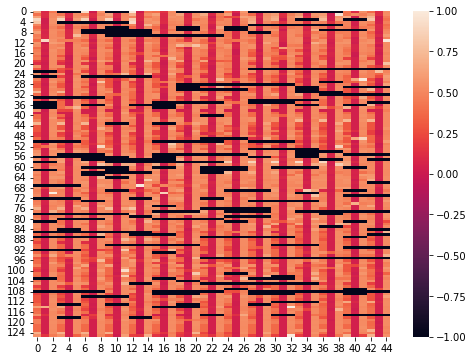

In [444]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(df_A_norm_copy, annot=False)

In [427]:
display(df_A)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,116.0,0.00160,1624.0,140.0,0.00022,1980.0,163.0,0.00022,2076.0,175.0,...,1991.0,78.0,0.00190,1945.0,72.0,0.00170,2021.0,66.0,0.00182,1960.0
1,70.0,0.00184,1968.0,74.0,0.00188,1977.0,78.0,0.00182,1846.0,112.0,...,2159.0,103.0,0.00008,3673.0,74.0,0.00900,1724.0,99.0,0.00194,2018.0
2,107.0,0.00164,1979.0,111.0,0.00180,2052.0,102.0,0.00166,2112.0,101.0,...,1995.0,115.0,0.00050,2190.0,117.0,0.00050,2071.0,125.0,0.00046,1742.0
3,155.0,0.00046,2080.0,152.0,0.00046,2293.0,150.0,0.00046,2133.0,152.0,...,1994.0,131.0,0.00054,2321.0,134.0,0.00054,1804.0,141.0,0.00054,1573.0
4,139.0,0.00046,2101.0,143.0,0.00046,2150.0,153.0,0.00046,1951.0,158.0,...,1976.0,85.0,0.00220,1600.0,84.0,0.00080,2011.0,84.0,0.00080,1804.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,65.0,0.00080,1984.0,65.0,0.00080,1972.0,65.0,0.00080,1971.0,65.0,...,1966.0,65.0,0.00080,1973.0,65.0,0.00080,1970.0,65.0,0.00080,1972.0
122,65.0,0.00080,1975.0,65.0,0.00080,1986.0,65.0,0.00080,1976.0,65.0,...,2006.0,65.0,0.00080,2006.0,65.0,0.00080,2042.0,67.0,0.00048,1898.0
123,65.0,0.00080,1947.0,65.0,0.00080,1966.0,65.0,0.00080,1948.0,65.0,...,1982.0,95.0,0.00080,1971.0,95.0,0.00080,1975.0,123.0,0.00082,1957.0
124,122.0,0.00080,1975.0,122.0,0.00080,1993.0,122.0,0.00080,1974.0,122.0,...,2082.0,67.0,0.00042,1954.0,67.0,0.00080,1851.0,80.0,0.00080,1822.0


In [ ]:
# ell-tuples stochastic gradient descent algorithm 

# Parameters
    # n: number of columns
    # x: value to approximate (true soln of Ax = y)
    # maxiter: Iteration count stopping condition (this is our m, row count)
    # p: probability that Q-tuple will be blocked out
    # ell: size of missing tuples
    # alpha: Iteration step size

def ltuple_msgd(A_tilde, y, maxiter, p, ell, alpha): 

    xhat = np.zeros((n, 1))

    current_iter = 1

    approx_err = np.zeros((1, maxiter))


    # Create Matrix Q for the update function
    L_matrix = np.zeros((n,n))
    
    for i = 1:ell:n-mod(n,ell)
        v = zeros(1,n);
        v(i:i+ell-1) = 1;
        L_matrix = L_matrix + (v' * v);
    end

    while current_iter < maxiter

        y(current_iter) = Ai*x; 

        A(current_iter,:) = Ai;
        A_tilde(current_iter,:) = Ai_tilde;

        gxk = (1/p^2) * ( Ai_tilde' * (Ai_tilde * xhat - p * y(current_iter)) ) - ((1-p)/p^2)*(L_matrix .* (Ai_tilde'*Ai_tilde)) * xhat;

        x_t1 = xhat - alpha * gxk;

        xhat = x_t1;

        current_iter = current_iter + 1;
        
        y_e = np.linalg.norm(A*xhat - y)**2;
        resid_err(1, current_iter) = y_e;